# FeedForward Neural Network for News Topic Classfication

In [8]:
# Import Libraries

import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Transform Raw texts into training and development data


In [10]:
# Loading input data and naming the 2 columns

train_df = pd.read_csv("/kaggle/input/data-topic/train.csv",names=["label","text"])
dev_df = pd.read_csv("/kaggle/input/data-topic/dev.csv",names=["label","text"])
test_df = pd.read_csv("/kaggle/input/data-topic/test.csv",names=["label","text"])

#trainsform the df to list
train_text = list(train_df['text'])
dev_text = list(dev_df['text'])
test_text = list(test_df['text'])

train_label = np.array(train_df['label'])
dev_label = np.array(dev_df['label'])
test_label = np.array(test_df['label'])

# Create input representations

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [11]:
stop_words = ['a','in','on','at','and','or',
              'to', 'the', 'of', 'an', 'by',
              'as', 'is', 'was', 'were', 'been', 'be',
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b',
                   stop_words=[], vocab=set()):

    pattern_re = re.compile(token_pattern)

    # Tokenize to get unigrams not in the stop list
    unigrams = [word for word in pattern_re.findall(str(x_raw).lower(),) if word not in stop_words]

    # Initialize the list for all n-grams
    ngrams_total = []

    if ngram_range[0] == 1:
        ngrams_total = unigrams

    # Generate n-grams from unigrams
    xtracted_features = []

    for n in range(ngram_range[0], ngram_range[1] + 1):
        if n == 1: continue

        args = [unigrams] + [unigrams[i:] for i in range(1, n)]

        xngram = list(zip(*args))
        xtracted_features.append(xngram)

    for i in xtracted_features:
        for j in i:
            ngrams_total.append(j)

    if len(vocab) > 0:
        ngrams_total = [word for word in ngrams_total if word in vocab]

    return ngrams_total

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [12]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=3, keep_topN=3000, stop_words=[]):

    doc_frequency = Counter()
    ngram_frequency = Counter()
    vocabulary = set()

    # Loop through each text to calculate frequencies
    for text in X_raw:
        ngrams = extract_ngrams(text, ngram_range, token_pattern, stop_words)
        doc_frequency.update(list(set(ngrams)))
        ngram_frequency.update(ngrams)

    # Create vocabulary based on minimum document frequency
    vocabulary = set([i for i in doc_frequency if doc_frequency[i] >= min_df])

    # Optionally keep top N ngrams
    if keep_topN > 0:
        vocabulary = set([i[0] for i in ngram_frequency.most_common(keep_topN) if i[0] in vocabulary])

    return vocabulary, doc_frequency, ngram_frequency

In [13]:
vocab,df,ngram_counts = get_vocab(train_text, ngram_range=(1,1), min_df = 4, keep_topN=3000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(dev_text, ngram_range=(1,1), min_df = 4, keep_topN=3000, stop_words=stop_words)
vocab_test, df_test, ngram_counts_test = get_vocab(test_text, ngram_range=(1,1), min_df = 4, keep_topN=3000, stop_words=stop_words)

print("Vocab: \n", list(vocab)[:50])
print("\n Raw frequencies of n-grams: \n", df.most_common()[:10])
print("\n Counts of each ngram in vocab \n", ngram_counts.most_common()[:10])

Vocab: 
 ['quest', 'supplies', 'buried', 'minutes', 'treat', 'braves', 'pending', 'band', 'expansion', 'young', 'credit', 'downer', 'hearing', 'ask', 'nothing', 'troublesome', 'side', 'great', 'income', 'make', 'unique', 'blue', 'depth', 'concern', 'milwaukee', 'number', 'ties', 'reliever', 'federal', 'caused', 'look', 'assistant', 'issued', 'carrier', 'sees', 'tech', 'try', 'others', 'euro', 'brian', 'sports', 'slow', 'vice', 'halliburton', 'promised', 'panthers', 'worst', 'hoped', 'response', 'reported']

 Raw frequencies of n-grams: 
 [('reuters', 631), ('said', 432), ('tuesday', 413), ('wednesday', 344), ('new', 325), ('after', 295), ('ap', 275), ('athens', 245), ('monday', 221), ('first', 210)]

 Counts of each ngram in vocab 
 [('reuters', 694), ('said', 440), ('tuesday', 415), ('new', 365), ('wednesday', 346), ('after', 304), ('athens', 293), ('ap', 276), ('monday', 221), ('first', 219)]


Create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [14]:
def transformation(vocab):
    # Create word to vocabulary ID mapping
    id_to_word = dict(enumerate(vocab))
    # Create vocabulary ID to word mapping
    word_to_id = {id: word for word, id in id_to_word.items()}

    return id_to_word, word_to_id

id2word_train, word2id_train = transformation(vocab)

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix.

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [16]:
def uni_indices(vocabulary, word2id):

    # Create an empty list to store the indices for each word in the vocabulary
    indices_list = []
    unique_words = list(vocabulary)

    # Loop through each word in the vocabulary
    for word_id in range(len(unique_words)):
        list_vocab = []
        # Check if each word has a corresponding ID in the mapping and collect the IDs
        for word in unique_words[word_id]:
            if word in word2id:
                id = word2id[word]
                list_vocab.append(id)
        indices_list.append(list_vocab)
    return unique_words, indices_list

# Apply the function to the train dataset
filtered_train_texts = uni_indices(train_text, word2id_train)
#print("Sample filtered train texts:", filtered_train_texts[:2])

In [17]:
# Then convert them into lists of indices in the vocabulary:

# prcessing all document make vocab
vocab_train, vocab_dev, vocab_test = [],[],[]
for text in train_text:
    vocab_train.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))
for text in dev_text:
    vocab_dev.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))
for text in test_text:
    vocab_test.append(extract_ngrams(text, ngram_range=(1,1),stop_words=stop_words))

train_unigram,train_indices = uni_indices(vocab_train,word2id_train)
dev_unigram,dev_indices = uni_indices(vocab_dev,word2id_train)
test_unigram,test_indices = uni_indices(vocab_test,word2id_train)

In [18]:
def preprocess_and_pad(data, labels):

    final_label = []
    final_data = []

    # Filter out empty documents and corresponding labels
    filtered_data = [d for d in data if d]
    filtered_labels = [labels[i] for i, d in enumerate(data) if d]

    # Calculate maximum length of the documents
    max_length = max(len(doc) for doc in filtered_data)
    print("Max length of each sentence: ", max_length)

    # Pad shorter documents with zeros
    padded_data = [doc + [0] * (max_length - len(doc)) for doc in filtered_data]

    # Ensure the lengths of labels and data are compatible
    for i in range(len(padded_data)):
        if len(padded_data[i])==0:
            continue
        else:
            final_data.append(padded_data[i])
            final_label.append(filtered_labels[i])

    return final_data, np.array(final_label)


X_tr,train_label = preprocess_and_pad(train_indices,train_label)
X_dev,dev_label = preprocess_and_pad(dev_indices,dev_label)
X_te,test_label = preprocess_and_pad(test_indices,test_label)

Max length of each sentence:  67
Max length of each sentence:  35
Max length of each sentence:  53


In [19]:
def list_shape(lst):
    if isinstance(lst, list):
        return [len(lst)] + list_shape(lst[0]) if lst else [0]
    else:
        return []

print("Shape of the list:", list_shape(X_tr))

Y_tr = train_label
Y_dev = dev_label
Y_te = test_label

Shape of the list: [2400, 67]


# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [20]:
def network_weights(vocab_size=3000, embedding_dim=70,
                    hidden_dim=[100], num_classes=3, init_val = 0.1):

    weights = {}

    # Initialize weights for the embedding layer
    weights[0] = np.random.uniform(low=-init_val, high=init_val, size=(vocab_size, embedding_dim)).astype(np.float32)

    # Initialize weights for hidden layers
    input_dim = embedding_dim
    for i, dim in enumerate(hidden_dim, 1):
        weights[i] = np.random.uniform(low=-init_val, high=init_val, size=(input_dim, dim)).astype(np.float32)
        input_dim = dim

    # Initialize weights for the output layer
    weights[len(hidden_dim) + 1] = np.random.uniform(low=-init_val, high=init_val, size=(input_dim, num_classes)).astype(np.float32)

    return weights

# Example usage
W = network_weights(vocab_size=3000, embedding_dim=70, hidden_dim=[100], num_classes=3, init_val=0.1)
for k, v in W.items():
    print(f"Layer {k} weights shape: {v.shape}")


Layer 0 weights shape: (3000, 70)
Layer 1 weights shape: (70, 100)
Layer 2 weights shape: (100, 3)


In [22]:
def softmax(z):
    e_z = np.exp(z-np.max(z))
    val = e_z / np.sum(e_z)
    return val

def categorical_loss(y, y_preds):
    l = -np.log(y_preds[y])
    return l

def relu(z):
    z = z.copy()
    a = np.maximum(0, z)
    return a

def relu_derivative(z):
    dz = z.copy()
    dz[dz <= 0] = 0
    dz[dz > 0] = 1
    return dz

def dropout_mask(size, dropout_rate):
    # Initialize a vector of 1
    dropout_vec = np.ones(size)

    dropout_vec[:int(size*dropout_rate)] = 0.0
    np.random.shuffle(dropout_vec)
    return dropout_vec

print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
[1. 1. 1. 0. 1. 1. 0. 1. 1. 1.]


# Forward Pass

Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer.

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [23]:
def forward_pass(x, W, dropout_rate=0.2):

    # Initialize lists
    processed_values = {}
    hidden_states = []
    activated_states = []
    dropout_masks = []
    num_layers = len(W) - 1

    # Processing input
    weighted_input = []
    input_length = len(x)

    # Assign initial layer
    for i in x:
        weighted_input.append(W[0][i])

    hidden_sum = np.sum(weighted_input, axis=0)
    hidden_sum = hidden_sum / input_length

    # Applying Relu and dropout mask
    activated_sum = relu(hidden_sum)
    dropout = dropout_mask(len(activated_sum), dropout_rate)
    processed_output = activated_sum * dropout

    hidden_states.append(hidden_sum)
    activated_states.append(activated_sum)
    dropout_masks.append(dropout)

    # Forward pass through layers
    for i in range(1, num_layers):
        hidden_output = np.dot(processed_output, W[i])

        activated_output = relu(hidden_output)
        dropout = dropout_mask(len(activated_output), dropout_rate)
        processed_output = activated_output * dropout
        hidden_states.append(hidden_output)
        activated_states.append(activated_output)
        dropout_masks.append(dropout)

    # Computing final prediction
    prediction = softmax(np.dot(processed_output, W[num_layers]))

    # Storing processed values in dictionary
    processed_values['h'] = hidden_states
    processed_values['a'] = activated_states
    processed_values['dropout_vecs'] = dropout_masks
    processed_values['y'] = prediction

    return processed_values

# Back Propagation

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [24]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    W_length = len(W)-1
    W0_shape = W[W_length].shape[0]
    W1_shape = W[W_length].shape[1]

    # y is the label array
    y_layer = np.zeros(W[W_length].shape[1])
    y_layer[y - 1] = 1
    # Compute the gradient on output layer
    delta_L = out_vals['y'] - y_layer
    output_val = out_vals['a'][-1] * out_vals['dropout_vecs'][-1]
    output_value = output_val.reshape(W0_shape,1)
    gradient_value = np.dot(output_value,delta_L.reshape(1, W1_shape))

     # Update the temp for layer
    Wk = np.dot(W[W_length],delta_L).reshape(1,W0_shape)
    g = out_vals['dropout_vecs'][W_length-1]
    temp = Wk * g
    # Update the W
    W[W_length] = W[W_length] - lr*gradient_value

    for i in range(1, W_length):

        # f'(z) update with activation der
        der_v = relu_derivative(out_vals['h'][W_length-i]).reshape(1,W[W_length+1-i].shape[0])

        # Compute the gradient on output layer
        temp = temp * der_v
        output_v1 = out_vals['a'][W_length-1-i]*out_vals['dropout_vecs'][W_length-1-i]
        output_value = output_v1.reshape(W[W_length-i].shape[0],1)
        gradient_value = np.dot(output_value,temp)
        temp_Wk = np.dot(W[W_length-i],temp.T).reshape(1,W[W_length-i].shape[0])
        temp_g  = out_vals['dropout_vecs'][W_length-1-i]
        temp = temp_Wk*temp_g

        # Calculate the new W
        W[W_length-i] = W[W_length-i] - lr*gradient_value


    # Update the W0 if freeze_emb==false
    if freeze_emb == False:
        x_array = np.zeros([W[0].shape[0],1])
        x_array[x] = 1.0
        lv_1 = relu_derivative(out_vals['h'][0]).reshape(1,W[0].shape[1])
        temp = temp*lv_1
        w_gradient = np.dot(x_array,temp)
        W[0] = W[0] - lr * w_gradient # w[0] not freezze

    return W

# Stochastic Gradient Descent

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [25]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    # History of losses for plotting or analysis
    train_losses = []
    valid_losses = []

    # Helper function to calculate the mean loss using categorical cross-entropy
    def calculate_loss(data_X, data_Y, weights, dropout_rate):
        individual_losses = []
        for x, y in zip(data_X, data_Y):
            outputs = forward_pass(x, weights, dropout_rate)
            prediction = outputs['y']
            print(prediction)

            # Calculate loss and collect it for averaging
            current_loss = categorical_loss(y - 1, prediction)
            individual_losses.append(current_loss)
        return np.mean(individual_losses)

    # Main loop for each epoch
    for epoch in range(epochs):
        # Random shuffle of indices for training data
        shuffle_indices = np.random.permutation(len(X_tr))
        X_tr = [X_tr[i] for i in shuffle_indices]
        Y_tr = [Y_tr[i] for i in shuffle_indices]

        # Loop over each data point and update weights
        for x, y in zip(X_tr, Y_tr):
            output_values = forward_pass(x, W, dropout)
            # Update weights based on gradients
            W = backward_pass(x, y, W, output_values, lr, freeze_emb)

        # Record the training and validation losses
        loss_train = calculate_loss(X_tr, Y_tr, W, dropout)
        train_losses.append(loss_train)

        loss_dev = calculate_loss(X_dev, Y_dev, W, dropout)
        valid_losses.append(loss_dev)

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {loss_train:.4f}")
        print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {loss_dev:.4f}")

    return W, train_losses, valid_losses


# Neural Network

Train and Evaluate by using the network_weights function followed by SGD with Back Propagation.

In [ ]:
W = network_weights(vocab_size=len(vocab),
                    embedding_dim = 70,
                    hidden_dim=[],
                    num_classes=3)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev=X_dev,
                            Y_dev=Y_dev,
                            lr=0.015,
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=20)

# Visualisation of Learning process

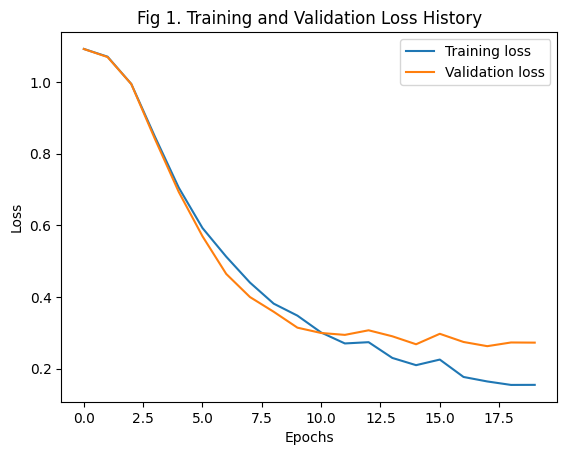

In [28]:
plt.plot(loss_tr, label='Training loss')
plt.plot(dev_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Fig 1. Training and Validation Loss History')
plt.legend()
plt.show()

### Figure **1** - Training and Validation Loss History
The graph shows a decrease in both training and validation losses as the model adjusts its weights to minimize the error between its predictions and the actual class labels. The slight fluctuations in the validation loss might indicate that the model could start to overfit the training data in later epochs, especially if these fluctuations become more pronounced or if the validation loss starts increasing in subsequent epochs beyond what was captured. By increasing the number of epochs, we can observe only slight improvement in the loss, hence we can continue using smaller epoch cycles.

The training and validation loss curves follow a similar curve trend which means that the lessons it's learning are broadly applicable, not just to the specific examples it's seen but also for unseen data. It is also successfully capturing underlying trends that are true more generally.



# Evaluation

Accuracy, Precision, Recall and F1-score

In [29]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) + 1
            for x,y in zip(X_te,Y_te)]
print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.8698553948832035
Precision: 0.8720700984098354
Recall: 0.8697398736529172
F1-Score: 0.8679274435865844


### Discuss how did you choose model hyperparameters ?

The hyperparameters embedding size, learning rate and dropout rate helps us achieve a better result to finetune our model. We uses grid search to get the best parameter that fits our data. By adjusting hyperparameters, you can find a balance between underfitting and overfitting. For example, increasing model complexity might improve training accuracy but can harm generalization to unseen data.

1. Learning rate - The step size should not be too high as it risks overshooting the minimum loss function. But a lower learning rate costs more computational power and takes too long to train. After experimenting with multiple values we find that the learning rate of 0.015 works best for the given data.

2. Embedding size - We experiment over the values 50, 70, 100 sizes. A larger embedding size allows each word to be represented with more features at the risk of overfitting. With 100 size, we find that the model shows a steep decrease in training loss, but struggles to perform well for the validation data. Hence we choose 70 embedding size.  

3. Dropout Rate - Dropout is a technique to drop randomly selected neurons at any time during training. They are temporarily removed in the forward transfer, and any heavy updates will not therefore result in transferring neurons. Out of the dropout rates [0.2, 0.3, 0.4] we find that 0.2 gives the optimal results. during training. They are forever "right to drop out". This means that their contributions to downstream neurons are temporarily removed in the forward transfer, and any heavy updates will not therefore result in transferring neurons.

In [ ]:
learning_rate_list = [0.005, 0.01, 0.05]
embedding_size_list = [50, 70]
drop_out_rate_list = [0.2, 0.4]
test_score = []
all_list = []
hyper_list = []

result = []

for dim in embedding_size_list:
    for lr in learning_rate_list:
        for drop in drop_out_rate_list:
            W = network_weights(vocab_size=len(vocab),
                    embedding_dim=dim,
                    hidden_dim=[],
                    num_classes=3,
                    init_val = 0.1)

           # We replace the dim, drop and lr for each iter
            W, loss_tr, dev_loss = SGD(X_tr,Y_tr,W,X_dev=X_dev, Y_dev=Y_dev,lr=lr, dropout = drop,freeze_emb=False,tolerance=0.01,epochs=10,print_progress=True)

            # Results and Scores
            preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.2)['y'])+1 for x,y in zip(X_te,test_label)]
            accuracy = accuracy_score(test_label,preds_te)
            precision = precision_score(Y_te,preds_te,average='macro')
            Recall =recall_score(Y_te,preds_te,average='macro')
            F_Score =f1_score(Y_te,preds_te,average='macro')
            score = [accuracy, precision, Recall,F_Score]

            current_result = {
                'embedding_dim': dim,
                'learning_rate': lr,
                'dropout_rate': drop,
                'accuracy': accuracy,
                'precision': precision,
                'recall': Recall,
                'f1_score': F_Score
            }
            result.append(current_result)

            test_score.append(accuracy)
            all_list.append([accuracy, precision, Recall, F_Score])
            hyper = [dim, lr, drop]
            hyper_list.append(hyper)


In [ ]:
best_result = max(test_score)
best_id = test_score.index(best_result)
best_hyper = hyper_list[best_id]
best_S = all_list[best_id]
print("The best parameter and the F1-score on test set")
print("emb_dim:", best_hyper[0], " lr:", best_hyper[1]," drop_rate:" ,best_hyper[2] ," Accuracy:", best_result, "A/P/R/F",best_S)